# Mini Project2


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [18]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [19]:
def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad = reg*Ui - Vj * ((Yij-mu) - np.dot(Ui,Vj) + ai + bj)

    foo = eta*grad

    return foo
        

def grad_V(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*Vj - Ui * ((Yij-mu) - np.dot(Ui,Vj) + ai + bj)

    foo = eta*grad

    return foo

def grad_a(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*ai + ((Yij-mu) - np.dot(Ui,Vj) + ai + bj)

    foo = eta*grad

    return foo

def grad_b(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*bj + ((Yij - mu) - np.dot(Ui,Vj) + ai + bj)

    foo = eta*grad

    return foo

def get_err(U, V, Y, a, b, mu, reg=0.0, reg_bias=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = Y.shape[0]
    err = 0
    for i in range(N):
        Y_idx = Y[i]
        Ui  = U[Y_idx[0]-1,:]
        Vj  = V[Y_idx[1]-1,:]
        Yij = Y_idx[2]
        ai  = a[Y_idx[0]-1]
        bj  = b[Y_idx[1]-1]

        err += ((Yij-mu) - np.dot(Ui,Vj) + ai + bj)**2

    err = err/(2*N)
    err = err + (reg/2)*(np.linalg.norm(U, ord='fro') + np.linalg.norm(V, ord='fro')) + (reg_bias/2)*(np.linalg.norm(a) + np.linalg.norm(b))

    return err


def train_model(M, N, K, eta, reg, reg_bias, Y, mu, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.uniform(-0.5,0.5,size=(M,K)) 
    V = np.random.uniform(-0.5,0.5,size=(N,K))
    a = np.random.uniform(-0.05,0.05,size=(M,1))
    b = np.random.uniform(-0.05,0.05,size=(N,1))

    err_0 = get_err(U, V, Y, a, b, mu, reg=reg, reg_bias=reg_bias) 

    N_y = Y.shape[0]

    for c in range(max_epochs):
        j = np.random.permutation(np.array(range(N_y)))
        for i in j:
            Y_idx  = Y[i]
            Ui  = U[Y_idx[0]-1,:]
            Vj  = V[Y_idx[1]-1,:]
            Yij = Y_idx[2]
            ai  = a[Y_idx[0]-1]
            bj  = b[Y_idx[1]-1]

            Ui  = Ui - grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            Vj  = Vj - grad_V(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            ai  = ai - grad_a(Ui, Yij, Vj, ai, bj, mu, reg_bias, eta)
            bj  = bj - grad_b(Ui, Yij, Vj, ai, bj, mu, reg_bias, eta)

            U[Y_idx[0]-1,:] = Ui
            V[Y_idx[1]-1,:] = Vj
            a[Y_idx[0]-1] = ai
            b[Y_idx[1]-1] = bj

        err = get_err(U, V, Y, a, b, mu, reg=reg, reg_bias=reg_bias)

        if c == 0:
            err_int = np.abs(err-err_0)
            err_1 = 0
        
        err_ratio = (err_1-err)/err_int

        if (err_ratio < eps) and (err_ratio > 0):
            err = get_err(U, V, Y, a, b, mu)
            break
        
        err_1 = err

    return U, V, a, b, err

In [20]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

N = train.shape[0]
mu = 0
for i in range(N):
    Y_idx = train[i]
    Yij   = Y_idx[2]
    mu += Yij
mu_train = mu/N

Factorizing with  943  users,  1682  movies.
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.01
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.016681005372000592
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.027825594022071243
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.046415888336127774
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0774263682681127
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.1291549665014884
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.21544346900318834
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.3593813663804626
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.5994842503189409
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 1.0


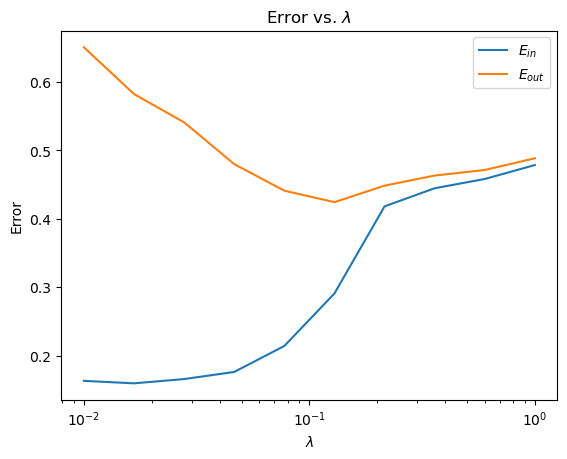

In [21]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

regs = np.logspace(-2,0,10)
eta = 0.05 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    reg_bias = reg
    U,V,a,b,err = train_model(M, N, K, eta, reg, reg_bias, train, mu_train, eps=0.01)
    E_in.append(err)
    E_out.append(get_err(U, V, test, a, b, mu_train))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. $\lambda$')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('set5_test_bias_reg.png')

Factorizing with  943  users,  1682  movies.
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.01
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.016681005372000592
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.027825594022071243
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.046415888336127774
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0774263682681127
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.1291549665014884
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.21544346900318834
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.3593813663804626
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.5994842503189409
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 1.0


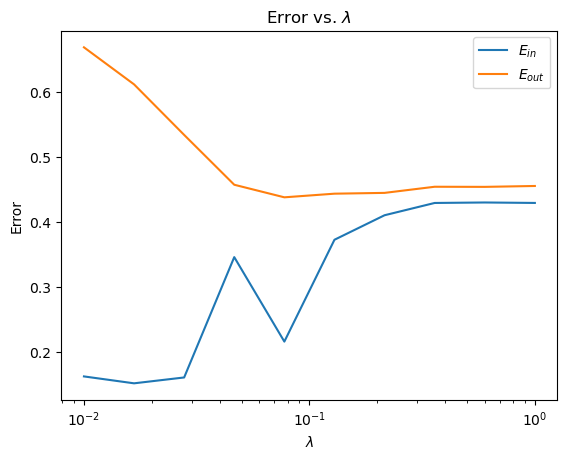

In [22]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

regs = np.logspace(-2,0,10)
eta = 0.05 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    reg_bias = 0
    U,V,a,b,err = train_model(M, N, K, eta, reg, reg_bias, train, mu_train, eps=0.005)
    E_in.append(err)
    E_out.append(get_err(U, V, test, a, b, mu_train))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. $\lambda$')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('set5_test_bias_reg.png')